# Deep Reinforcement Learning

In this advanced task, we'll perform deep reinforcement learning using the DQN family of algorithms on stock market data. We'll use Yahoo Finance to fetch stock data and implement various DQN variants (DQN, Double DQN, Duelling Double DQN).


#Fetch Stock Market Data

In [12]:
import yfinance as yf
import pandas as pd

# Fetch stock data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Moving_Average'] = df['Close'].rolling(window=14).mean()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df = df.dropna()
    return df

# Example: Fetch data for Apple from 2020 to 2023
data = fetch_data('AAPL', '2020-01-01', '2023-01-01')
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-01-23  79.480003  79.889999  78.912498  79.807503  77.546776  104472000   
2020-01-24  80.062500  80.832497  79.379997  79.577499  77.323280  146537600   
2020-01-27  77.514999  77.942497  76.220001  77.237503  75.049553  161940000   
2020-01-28  78.150002  79.599998  78.047501  79.422501  77.172646  162234000   
2020-01-29  81.112503  81.962502  80.345001  81.084999  78.788078  216229200   

            Moving_Average      MACD       RSI  
Date                                            
2020-01-23       77.628929  1.178154  0.440285  
2020-01-24       78.001786  1.194728  0.488690  
2020-01-27       78.165179  1.007431  0.223635  
2020-01-28       78.509822  1.023510  0.457692  
2020-01-29       78.887500  1.157064  0.491978  


#Create the Environment

In [18]:
import gym
from gym import spaces
import numpy as np
import yfinance as yf
import pandas as pd

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.current_step = 0

        # Define action and observation space
        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [price, moving average, moving average convergence divergence, relative strength index]
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

        # Initial investment amount
        self.initial_balance = 10000
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance

    def _next_observation(self):
        obs = np.array([
            self.df.loc[self.current_step, 'Close'],
            self.df.loc[self.current_step, 'Moving_Average'],
            self.df.loc[self.current_step, 'MACD'],
            self.df.loc[self.current_step, 'RSI']
        ])
        return obs

    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, 'Close']

        if action == 0:  # Buy
            shares_bought = self.cash_in_hand // current_price
            self.cash_in_hand -= shares_bought * current_price
            self.stock_owned += shares_bought

        elif action == 1:  # Hold
            pass

        elif action == 2:  # Sell
            self.cash_in_hand += self.stock_owned * current_price
            self.stock_owned = 0

        self.net_worth = self.cash_in_hand + self.stock_owned * current_price
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def step(self, action):
        self._take_action(action)

        self.current_step += 1

        if self.current_step >= len(self.df):
            self.current_step = 0  # Reset for the next episode

        obs = self._next_observation()
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0

        return obs, reward, done, {}

    def reset(self):
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.current_step = 0

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.cash_in_hand}')
        print(f'Shares held: {self.stock_owned}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

# Fetch stock data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Moving_Average'] = df['Close'].rolling(window=14).mean()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df = df.dropna()
    return df

# Fetch data for Apple from 2020 to 2023
data = fetch_data('AAPL', '2020-01-01', '2023-01-01')

# Initialize environment
env = StockTradingEnv(data)
obs = env.reset()
print(obs)


[*********************100%%**********************]  1 of 1 completed

[79.80750275 77.62892859  1.17815384  0.44028504]


#Implement Experience Replay Buffer

The experience replay buffer stores past experiences for training the agent.

In [1]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)



#Implement DQN, Double DQN, and Duelling Double DQN
We will use PyTorch for the neural network implementation.

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-bdf9606c9d2e>:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.tensor(states, dtype=torch.float32)


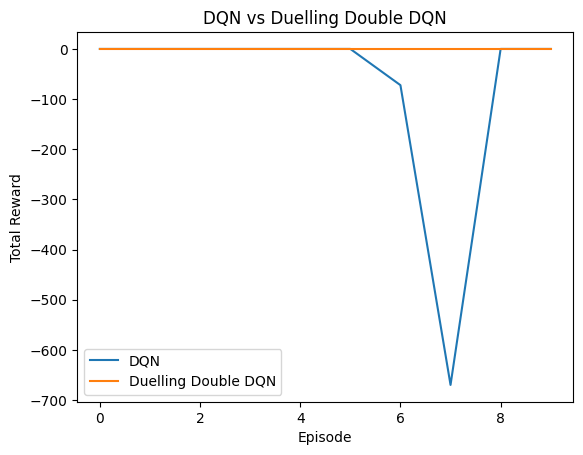

In [3]:
import gym
from gym import spaces
import numpy as np
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.current_step = 0

        # Define action and observation space
        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [price, moving average, moving average convergence divergence, relative strength index]
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

        # Initial investment amount
        self.initial_balance = 10000
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance

    def _next_observation(self):
        obs = np.array([
            self.df.loc[self.current_step, 'Close'],
            self.df.loc[self.current_step, 'Moving_Average'],
            self.df.loc[self.current_step, 'MACD'],
            self.df.loc[self.current_step, 'RSI']
        ])
        return obs

    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, 'Close']

        if action == 0:  # Buy
            shares_bought = self.cash_in_hand // current_price
            self.cash_in_hand -= shares_bought * current_price
            self.stock_owned += shares_bought

        elif action == 1:  # Hold
            pass

        elif action == 2:  # Sell
            self.cash_in_hand += self.stock_owned * current_price
            self.stock_owned = 0

        self.net_worth = self.cash_in_hand + self.stock_owned * current_price
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def step(self, action):
        self._take_action(action)

        self.current_step += 1

        if self.current_step >= len(self.df):
            self.current_step = 0  # Reset for the next episode

        obs = self._next_observation()
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0 or self.current_step == len(self.df) - 1  # Update done condition

        return obs, reward, done, {}

    def reset(self):
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.current_step = 0

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_wworth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.cash_in_hand}')
        print(f'Shares held: {self.stock_owned}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

# Fetch stock data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Moving_Average'] = df['Close'].rolling(window=14).mean()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df = df.dropna()
    return df
# Fetch data for Apple from 2020 to 2023
data = fetch_data('AAPL', '2020-01-01', '2023-01-01')

# Initialize environment
env = StockTradingEnv(data)

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the Duelling Q-Network
class DuellingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuellingQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)

        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        return value + (advantage - advantage.mean())

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

# Training and updating functions
def train_dqn(env, replay_buffer, q_network, target_q_network, optimizer, batch_size, gamma):
    if replay_buffer.size() < batch_size:
        return

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = q_network(states).gather(1, actions)
    next_q_values = target_q_network(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def update_target_network(q_network, target_q_network):
    target_q_network.load_state_dict(q_network.state_dict())

# Hyperparameters
state_size = 4
action_size = 3
buffer_size = 10000
batch_size = 64
gamma = 0.99
learning_rate = 0.001
target_update = 10
max_episodes = 10
max_steps = 10

# Initialize environment, networks, optimizer, and replay buffer
env = StockTradingEnv(data)
replay_buffer = ReplayBuffer(buffer_size)

q_network = QNetwork(state_size, action_size)
target_q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

duelling_q_network = DuellingQNetwork(state_size, action_size)
duelling_target_q_network = DuellingQNetwork(state_size, action_size)
duelling_optimizer = optim.Adam(duelling_q_network.parameters(), lr=learning_rate)

update_target_network(q_network, target_q_network)
update_target_network(duelling_q_network, duelling_target_q_network)

# Training loop
def train_model(q_network, target_q_network, optimizer):
    rewards_all_episodes = []
    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = np.argmax(q_network(torch.tensor(state, dtype=torch.float32)).detach().numpy())
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            train_dqn(env, replay_buffer, q_network, target_q_network, optimizer, batch_size, gamma)

            if done:
                print(f"Episode {episode} finished after {step+1} steps with total reward {total_reward}")
                break

        rewards_all_episodes.append(total_reward)
        if episode % target_update == 0:
            update_target_network(q_network, target_q_network)

    return rewards_all_episodes

# Train DQN
dqn_rewards = train_model(q_network, target_q_network, optimizer)

# Train Duelling Double DQN
duelling_rewards = train_model(duelling_q_network, duelling_target_q_network, duelling_optimizer)

# Plotting the results
plt.plot(dqn_rewards, label='DQN')
plt.plot(duelling_rewards, label='Duelling Double DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN vs Duelling Double DQN')
plt.legend()
plt.show()


#Trading Environment

In [1]:
class TradingEnv:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.stock_held = 0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        return [self.balance, self.stock_held, self.data.iloc[self.current_step]['Close']]

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        self.current_step += 1

        if action == 0:  # Hold
            reward = 0
        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.stock_held += 1
                self.balance -= current_price
                reward = 0
            else:
                reward = -1  # Penalty for trying to buy without enough balance
        elif action == 2:  # Sell
            if self.stock_held > 0:
                self.stock_held -= 1
                self.balance += current_price
                reward = current_price - self.data.iloc[self.current_step-1]['Close']  # Reward is profit from the sale
            else:
                reward = -1  # Penalty for trying to sell without holding any stock

        if self.current_step >= len(self.data) - 1:
            self.done = True
        else:
            self.done = False

        next_state = self._get_state()
        return next_state, reward, self.done


#Experience Replay Buffer

In [2]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def size(self):
        return len(self.buffer)


#Deep Q-Network (DQN)

In [3]:
def build_dqn(state_size, action_size):
    model = Sequential()
    model.add(Input(shape=(state_size,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model


#Double DQN

In [4]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 32
        self.train_start = 1000
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(np.array([state]))[0]
        return np.argmax(q_values)

    def replay(self):
        if self.memory.size() < self.train_start:
            return

        batch = self.memory.sample(self.batch_size)
        if batch is None:
            return

        states, actions, rewards, next_states, dones = batch

        target = self.model.predict(states)
        target_next = self.model.predict(next_states)
        target_val = self.target_model.predict(next_states)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                a = np.argmax(target_next[i])
                target[i][actions[i]] = rewards[i] + self.gamma * (target_val[i][a])

        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


#Duelling Double DQN

In [5]:
# Define the Duelling Q-Network
class DuellingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuellingQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)

        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        return value + (advantage - advantage.mean())

#Training the Agents

In [6]:
def train_agent(agent, env, num_episodes):
    rewards = []
    for e in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while not env.done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.memory.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if agent.memory.size() > agent.train_start:
                agent.replay()
            if done:
                break

        agent.update_target_model()
        rewards.append(total_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    return rewards
